<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#RidgeClassifier" data-toc-modified-id="RidgeClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RidgeClassifier</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from pymystem3 import Mystem
m = Mystem()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from itertools import product

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.shape

(159292, 3)

In [8]:
df.duplicated().sum()

0

In [9]:
# Проверим балланс классов
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [10]:
df.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

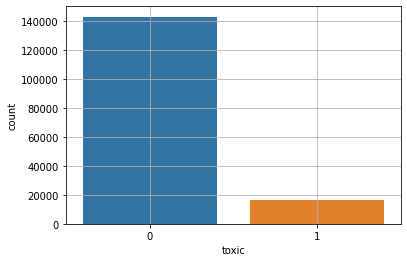

In [11]:
sns.countplot(data=df, x='toxic')
plt.title('')
plt.grid()

In [12]:
#Процентное соотношение токсичных комментариев:
toxic_ratio = pd.Series(df['toxic']==1).sum()/df.shape[0]
print('toxic ratio: {:.2%}'.format(toxic_ratio))

toxic ratio: 10.16%


In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

In [14]:
#Функция очистки от лишних символов:

def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return ' '.join(text.split())

In [15]:
train_corpus = df['text']

In [16]:
#затем каждый корпус лемматизируем с ее использованием:

lemmatizer = WordNetLemmatizer()
lemm_train_corpus = []
for i in range(len(train_corpus)):
    word_list = nltk.word_tokenize(train_corpus[i])
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, 'n') for w in word_list])
    lemm_train_corpus.append(clear_text(lemmatized_output))

In [17]:
df['text'] = lemm_train_corpus

In [31]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation Why the edits made under my userna...,0
1,1,D aww He match this background colour I m seem...,0
2,2,Hey man I m really not trying to edit war It s...,0
3,3,More I ca n t make any real suggestion on impr...,0
4,4,You sir are my hero Any chance you remember wh...,0


In [18]:
# Список стоп слов
stopwords = set(nltk_stopwords.words('english'))

### Вывод: 

- 159292 строка
- Дубликатов и пропусков нет
- 2 столбца: toxic, text
- В столбце text содержатся тексты твитов
- В столбе toxic булевые значения является ли данный твит токсичным или нет
- примерно 90% твитов не токсичны


- Проверили данные
- Убрали знаки препинания и символы
- Вычислили процентное соотношение токсичных комментариев
- Провели лемматизацию 
- Убрали стоп-слова

## Обучение

In [19]:
#Разделю выборки

target=df['toxic'].values
features = df['text']

features_other, features_test, target_other, target_test = train_test_split(features, target, test_size = .1, random_state = 42)
features_train, features_valid, target_train, target_valid = train_test_split(features_other, target_other, shuffle=False, test_size=0.25, random_state = 42)

features_train.shape[0], features_valid.shape[0], features_test.shape[0]

(107521, 35841, 15930)

In [20]:
#TFIDF векторизация

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tfidf_train = count_tf_idf.fit_transform(features_train)
tfidf_valid = count_tf_idf.transform(features_valid)
tfidf_test = count_tf_idf.transform(features_test)

### LogisticRegression

In [21]:
%%time
pipe = Pipeline([
    (
    ('model', LogisticRegression(random_state=1, solver='liblinear', max_iter=200))
    )
    ])


param_grid = [
        {

            'model': [LogisticRegression(random_state=42, solver='liblinear')],
            'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(1,15,3))
        }
]
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid = grid.fit(tfidf_train, target_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters is: {'model': LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear'), 'model__C': 4, 'model__penalty': 'l1'}
Best score is: 0.7689025108249977
CPU times: user 1min 8s, sys: 1min 35s, total: 2min 44s
Wall time: 2min 44s


LogisticRegression показала подходящее значение метрики 

### RandomForestClassifier

In [23]:
# %%time
# params_forest = {
#     'n_estimators': list(range(50,300,50)),
#     'max_depth':[5,15],
#     'max_features' : list(range(1,20, 2))
# }


# model_forest = RandomForestClassifier(random_state=12345)
                                 
# grid = GridSearchCV(model_forest, param_grid=params_forest, scoring='f1', cv=3, verbose=True, n_jobs=-1)
# best_grid = grid.fit(tfidf_train, target_train)
# print('Best parameters is:', grid.best_params_)
# print('Best score is:', grid.best_score_)

У случайного леса получилось нулевое значение метрики (закомментила)

###  RidgeClassifier

In [24]:
%%time

model_clf = RidgeClassifier(alpha = 1, normalize = True)
model_clf.fit(tfidf_train, target_train)
predicted_clf = model_clf.predict(tfidf_valid)
f1_clf = f1_score(target_valid, predicted_clf)
f1_clf

CPU times: user 2.79 s, sys: 6.16 s, total: 8.95 s
Wall time: 8.95 s


0.5607268681624328

Совсем плохой результат метрики

### LinearSVC

In [25]:
%%time

f1_svc = dict()
for i in product([{'C':0.1},{'C':1.0} ,{'C':2.5}],
              [{'max_iter':5},{ 'max_iter':10}, {'max_iter':100}]
              ):
    model_svc = LinearSVC(random_state = 12345,**i[0],**i[1])
    model_svc.fit(tfidf_train, target_train)
    predicted_svc = model_svc.predict(tfidf_valid)
    f1_svc = f1_score(target_valid, predicted_svc)
    print('i=', i, 'f1_svc', f1_svc)

i= ({'C': 0.1}, {'max_iter': 5}) f1_svc 0.7354497354497356
i= ({'C': 0.1}, {'max_iter': 10}) f1_svc 0.7357804232804233
i= ({'C': 0.1}, {'max_iter': 100}) f1_svc 0.7357804232804233
i= ({'C': 1.0}, {'max_iter': 5}) f1_svc 0.7818740399385561
i= ({'C': 1.0}, {'max_iter': 10}) f1_svc 0.7838616714697406
i= ({'C': 1.0}, {'max_iter': 100}) f1_svc 0.784123617633692
i= ({'C': 2.5}, {'max_iter': 5}) f1_svc 0.7761747187293184
i= ({'C': 2.5}, {'max_iter': 10}) f1_svc 0.7785234899328859
i= ({'C': 2.5}, {'max_iter': 100}) f1_svc 0.775902901124926
CPU times: user 4.18 s, sys: 301 ms, total: 4.48 s
Wall time: 4.59 s


Модель LinearSVC с параметрами 'C': 1.0, 'max_iter': 100 f1_svc 0.784123617633692 наиболее подходящая. 

Далее закомментила CatBoostClassifier и LGBMClassifier так как грузятся по часу и значение метрики хуже, чем у логистической регрессии и LinearSVC

### CatBoostClassifier

In [26]:
# %%time

# params_cat = {
#     'depth' : [5, 10], 
#     'learning_rate' : [0.03], #брала 0.03, 0.06, 0.1
#     'iterations' : [300], #брала 100, 200, 300
#     'verbose' : [100]
# }

# catboost = CatBoostClassifier(random_state=43)

# cat_grid = GridSearchCV(catboost,param_grid=params_cat, scoring='f1', cv=3, verbose=True, n_jobs=-1)
# best_grid = grid.fit(tfidf_train, target_train)
# print('Best parameters is:', grid.best_params_)
# print('Best score is:', grid.best_score_)

### LGBMClassifier

In [27]:
# %%time


# LightGBM_model = LGBMClassifier()
# hyperparams = [{'max_depth' : [3,10], 
#                 'learning_rate':[0.03], # 0.03, 0.1, 0.3
#                 'n_estimators' : [1000],  # 200, 500, 1000
#                 'random_state':[12345]}]
# clf = GridSearchCV(LightGBM_model, hyperparams, scoring='f1',cv=3)
# clf.fit(tfidf_train, target_train)
# print('Best parameters is:')
# print()
# LGBM_best_params = clf.best_params_
# print(LGBM_best_params)
# print()
# print('Best score is:', clf.best_score_)

### Вывод: 

Модели Логистическая регрессия и LinearSVC показали подходящие результаты метрики, модель RidgeClassifier показала результат намного хуже, RandomForestClassifier показала нулевой результат.

## Тестирование 

Протестирую модель LinearSVC

In [28]:
best_model = LinearSVC(random_state = 12345,  max_iter= 100) 

best_model.fit(tfidf_train, target_train)
predicted_test = best_model.predict(tfidf_test) 
f1 = f1_score(target_test, predicted_test) 
f1

0.7793656326246079

Удалось достичь нужной выличены f1-меры на тестовой выборке с параметром max_iter = 100.

Также решила обучить модель логистической регрессии

In [29]:
model = LogisticRegression(random_state=42, C = 4, penalty = 'l1', solver='liblinear', max_iter=200)
model.fit(tfidf_train, target_train)
valid_pred = model.predict(tfidf_valid)
f1_score(target_valid, valid_pred)

0.7846336398694749

In [30]:
test_pred = model.predict(tfidf_test)
print(metrics.classification_report(target_test, test_pred), metrics.f1_score(target_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14314
           1       0.87      0.71      0.78      1616

    accuracy                           0.96     15930
   macro avg       0.92      0.85      0.88     15930
weighted avg       0.96      0.96      0.96     15930
 0.7801225323349217


### Вывод: 

На основе тестирования можно сделать вывод, что лучший результат метрики был достигнут на модели Логистической регрессии

## Выводы

- Подготовили данные
- Убрали знаки препинания и символы
- Вычислили процентное соотношение токсичных комментариев
- Провели лемматизацию
- Разделили выборки
- Обучили разные модели 
- Провели тестирование лучших моделей
- Исходя из анализа модель Логистической регрессии оказалась лучшей с результатом метрики 0.780